In [83]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import nltk
import re
from tensorflow import keras

2025-03-13 14:16:14.466522: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-13 14:16:14.746165: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-13 14:16:14.947632: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741875375.252277    4930 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741875375.343794    4930 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-13 14:16:15.976677: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

In [46]:
# Read CSV file
file_path = r"charliehebdo-all-rnr-threads.csv"
df = pd.read_csv(file_path)


In [47]:
df.groupby('rumour')['id'].nunique()

rumour
0.0    1555
1.0     447
Name: id, dtype: int64

In [53]:
df.time = pd.to_datetime(df.time, format="mixed", errors="coerce")
df.reply_time = pd.to_datetime(df.reply_time, format="mixed", errors="coerce")

### Time for replies x Number of replies

In [54]:
df  = df[(~df.time.isna()==True)&((~df.reply_time.isna()==True))]

In [55]:
 df['time_diff']=(df.reply_time - df.time).dt.total_seconds()/60

In [56]:
df['reply_number'] = df.groupby('id')['time_diff'].rank(method='dense')

In [57]:
df_reply_time = (df.groupby(['reply_number','rumour'])['time_diff'].median()).to_frame(name='time_diff_minutes').reset_index()
df_reply_time.reply_number = df_reply_time.reply_number.astype('int')

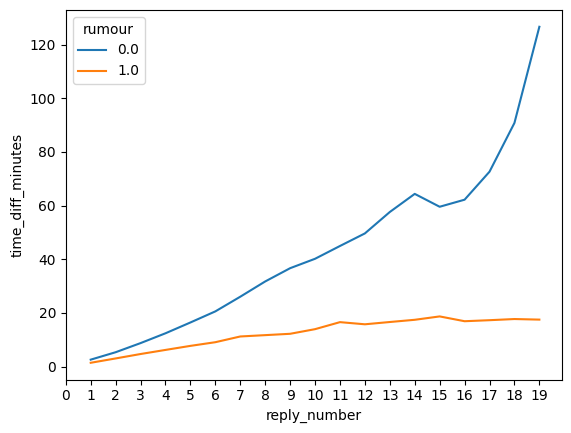

In [58]:
sns.lineplot(data=df_reply_time, x='reply_number', y='time_diff_minutes',hue='rumour')
# Set custom x-axis values
custom_xticks = np.arange(0,20,1) # specify the desired x-axis values
plt.xticks(custom_xticks)
plt.show()

#### Time for first reply x Number of replies

In [59]:
df_first_tm_diff = df.groupby(['id','rumour']).agg(replies=('time_diff','count')\
                      ,first_time_diff=('time_diff','first')).reset_index()\
                  .groupby(['rumour','replies'])['first_time_diff'].median()\
                  .to_frame().reset_index()

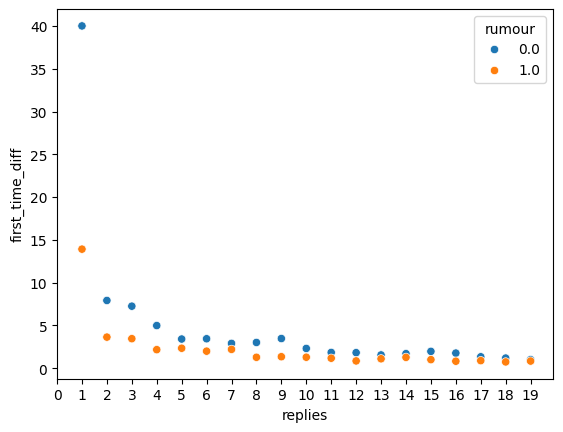

In [60]:
sns.scatterplot(data=df_first_tm_diff, x='replies', y='first_time_diff',hue='rumour')
custom_xticks = np.arange(0,20,1) # specify the desired x-axis values
plt.xticks(custom_xticks)
plt.show()

#### Number of replies x Retweet counts

In [61]:
df_posts = df[['id','text','followers','favorite_count','retweet_count','verified',\
  'rumour','user_id']].drop_duplicates().merge(df.groupby(['id']).agg(replies=(\
  'time_diff','count'),first_time_diff=('time_diff','first')).reset_index(),\
  on="id",how="left")

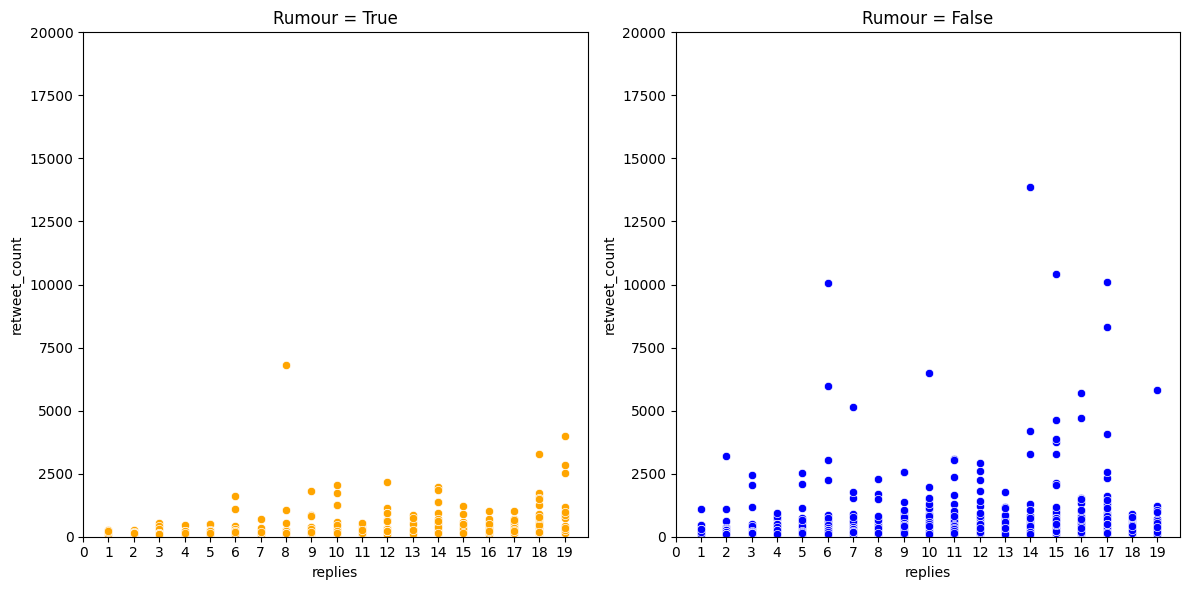

In [62]:
# Create subplots with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Scatter plot for rumour == True
sns.scatterplot(data=df_posts[df_posts['rumour'] == 1], x='replies', y='retweet_count',color='orange', ax=axs[0])
axs[0].set_title('Rumour = True')
#axs[0].set_xlim(0, 5000)
axs[0].set_ylim(0, 20000)
custom_xticks = np.arange(0, 20, 1)
axs[0].set_xticks(custom_xticks)

# Scatter plot for rumour == False
sns.scatterplot(data=df_posts[df_posts['rumour'] == 0], x='replies', y='retweet_count',color='blue', ax=axs[1])
axs[1].set_title('Rumour = False')
#axs[1].set_xlim(0, 5000)
axs[1].set_ylim(0, 20000)
custom_xticks = np.arange(0, 20, 1)
axs[1].set_xticks(custom_xticks)

plt.tight_layout()
plt.show()

#### Favorite counts x Retweet counts

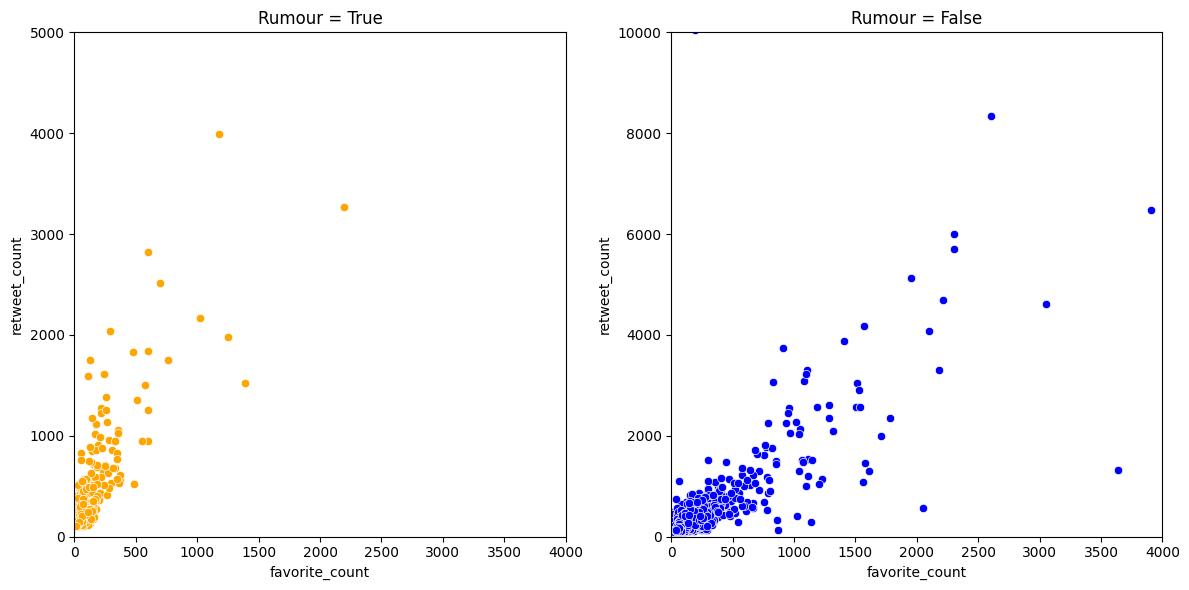

In [63]:
# Create subplots with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Scatter plot for rumour == True
sns.scatterplot(data=df_posts[df_posts['rumour'] == 1], x='favorite_count', y='retweet_count',color='orange', ax=axs[0])
axs[0].set_title('Rumour = True')
axs[0].set_xlim(0, 4000)
axs[0].set_ylim(0, 5000)

# Scatter plot for rumour == False
sns.scatterplot(data=df_posts[df_posts['rumour'] == 0], x='favorite_count', y='retweet_count',color='blue', ax=axs[1])
axs[1].set_title('Rumour = False')
axs[1].set_xlim(0, 4000)
axs[1].set_ylim(0, 10000)


plt.tight_layout()
plt.show()

#### Retweet count x Time for first reply

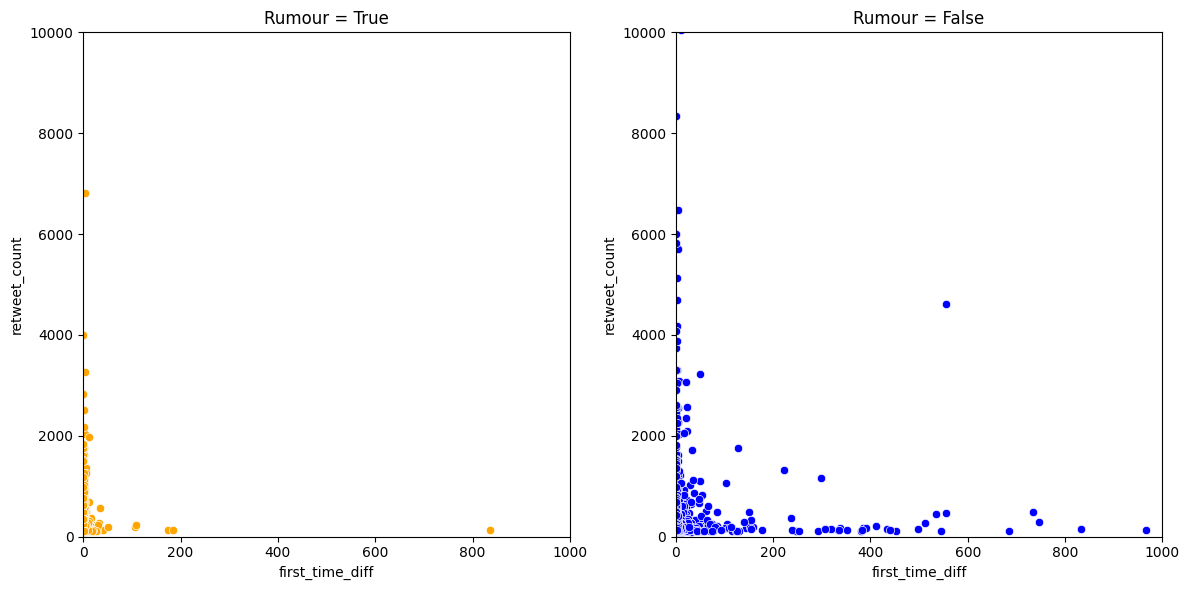

In [64]:
# Create subplots with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Scatter plot for rumour == True
sns.scatterplot(data=df_posts[df_posts['rumour'] == 1], x='first_time_diff', y='retweet_count',color='orange', ax=axs[0])
axs[0].set_title('Rumour = True')
axs[0].set_xlim(0, 1000)
axs[0].set_ylim(0, 10000)

# Scatter plot for rumour == False
sns.scatterplot(data=df_posts[df_posts['rumour'] == 0], x='first_time_diff', y='retweet_count',color='blue', ax=axs[1])
axs[1].set_title('Rumour = False')
axs[1].set_xlim(0, 1000)
axs[1].set_ylim(0, 10000)


plt.tight_layout()
plt.show()

#### Followers vs Retweet counts

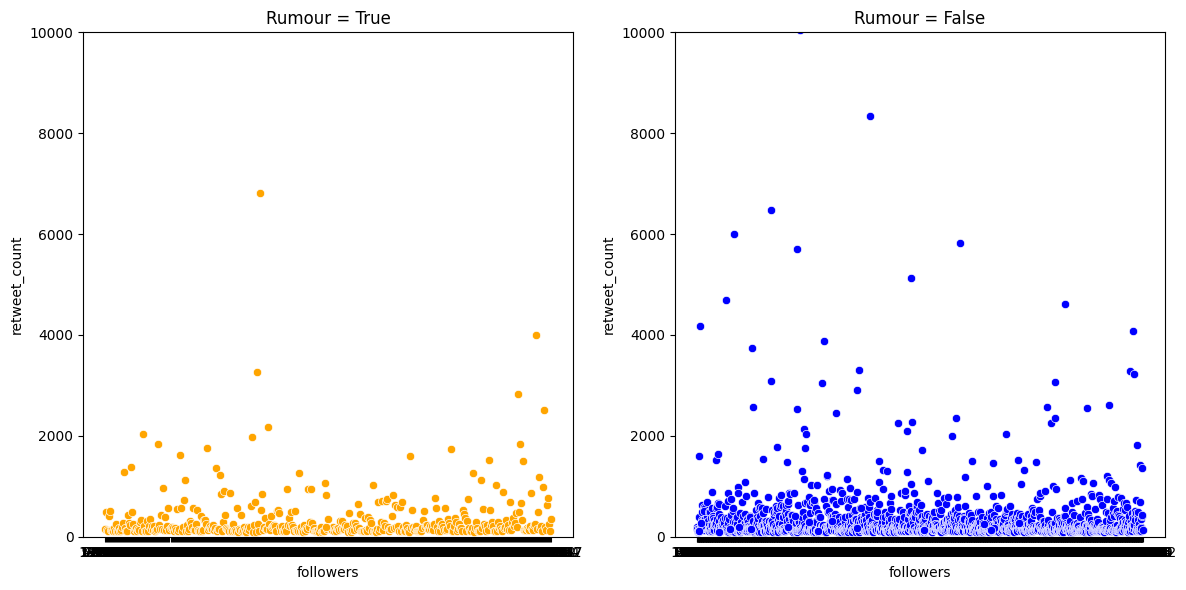

In [65]:
# Create subplots with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Scatter plot for rumour == True
sns.scatterplot(data=df_posts[df_posts['rumour'] == 1], x='followers', y='retweet_count',color='orange', ax=axs[0])
axs[0].set_title('Rumour = True')
#axs[0].set_xlim(0, 1000)
axs[0].set_ylim(0, 10000)

# Scatter plot for rumour == False
sns.scatterplot(data=df_posts[df_posts['rumour'] == 0], x='followers', y='retweet_count',color='blue', ax=axs[1])
axs[1].set_title('Rumour = False')
#axs[1].set_xlim(0, 1000)
axs[1].set_ylim(0, 10000)


plt.tight_layout()
plt.show()

#### Word embeddings

In [74]:
# Download NLTK stopwords
nltk.download('stopwords')

english_stopwords = nltk.corpus.stopwords.words('english')

# function for cleaning data
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
    return input_txt


def clean_text(
    string: str,
    punctuations=r'''!()-[]{};:'"\,<>./?@#$%^&*_~''',
    stop_words=english_stopwords) -> str:
    """
    A method to clean text
    """
    # Cleaning the urls
    string = re.sub(r'https?://\S+|www\.\S+', '', string)

    # Cleaning the html elements
    string = re.sub(r'<.*?>', '', string)

    # Removing the punctuations
    for x in string.lower():
        if x in punctuations:
            string = string.replace(x, "")

    # Converting the text to lower
    string = string.lower()

    # Removing stop words
    string = ' '.join([word for word in string.split() if word not in stop_words])

    # Cleaning the whitespaces
    string = re.sub(r'\s+', ' ', string).strip()

    return string

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [75]:
df_posts['clean_text'] = np.vectorize(remove_pattern)(df_posts['text'], "@[\w]*")
df_posts['clean_text'] = df_posts['clean_text'].str.replace("[^a-zA-Z#]", " ").apply(clean_text)

<>:1: SyntaxWarning: invalid escape sequence '\w'
<>:1: SyntaxWarning: invalid escape sequence '\w'
/tmp/ipykernel_4930/1199893929.py:1: SyntaxWarning: invalid escape sequence '\w'
  df_posts['clean_text'] = np.vectorize(remove_pattern)(df_posts['text'], "@[\w]*")


In [85]:
# create the dictionary
tokenizer =  keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(df_posts['clean_text'])

In [86]:
print("Longest length is: ",df_posts.clean_text.str.len().max())

Longest length is:  127


In [88]:
def embedding_vocab(filepath, word_index,embedding_dim):
    vocab_size = len(word_index) + 1


    embedding_matrix_vocab = np.zeros((vocab_size,
                                       embedding_dim))

    with open(filepath, encoding="utf8") as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word]
                embedding_matrix_vocab[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]
    return embedding_matrix_vocab

In [89]:
#!wget https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
#!unzip -q glove.6B.zip

In [90]:
embedding_dim = 100
embedding_matrix_vocab = embedding_vocab(
    'glove.6B.100d.txt', tokenizer.word_index,
embedding_dim)

In [91]:
tokenizer.word_index['terrorist']

32

In [92]:
embedding_matrix_vocab[32]

array([ 2.61329988e-04,  3.27170014e-01, -5.27490020e-01, -6.99689984e-01,
        5.68310022e-01, -1.64810002e-01, -4.63490009e-01, -1.06669998e+00,
        7.11060017e-02,  1.34609997e+00,  4.05539989e-01,  7.92929977e-02,
        5.70400000e-01,  4.85280007e-01,  1.60490006e-01,  1.35200000e+00,
       -6.25209987e-01, -9.24429968e-02, -9.80400026e-01,  4.38950002e-01,
        1.12310000e-01, -2.42149994e-01,  2.77770013e-01, -7.61640012e-01,
       -9.54079986e-01,  3.74170005e-01,  4.12420005e-01,  9.61040035e-02,
        8.47470015e-02,  2.55450010e-01,  4.38340008e-01, -1.25060007e-01,
       -1.60779998e-01,  1.24240004e-01,  1.52309999e-01, -1.64389998e-01,
       -3.27900015e-02, -4.91930008e-01,  5.06540000e-01,  2.00389996e-01,
       -5.87509990e-01,  2.10769996e-01,  1.22230005e+00,  5.09630024e-01,
        1.11189997e+00, -2.26009995e-01,  9.64810014e-01,  6.00089990e-02,
       -6.84650004e-01, -3.28599989e-01,  2.12280005e-02,  9.96940017e-01,
        5.38230002e-01,  

In [93]:
from sklearn.metrics.pairwise import cosine_similarity

def cosine_similarities(embedding_matrix, word_index, word):
    idx = word_index.get(word)
    if idx is None:
        return None
    vector = embedding_matrix[idx].reshape(1, -1)
    similarities = cosine_similarity(vector, embedding_matrix)
    return similarities[0]

In [94]:
similarities = cosine_similarities(embedding_matrix_vocab, tokenizer.word_index, 'terrorist')
similar_indices = similarities.argsort()[::-1]
for idx in similar_indices[1:6]:  # excluding the word itself
    word = tokenizer.index_word[idx]
    print(word)

terror
terrorists
terrorism
attacks
qaeda


In [95]:
similarities = cosine_similarities(embedding_matrix_vocab, tokenizer.word_index, 'cowards')
similar_indices = similarities.argsort()[::-1]
for idx in similar_indices[1:6]:  # excluding the word itself
    word = tokenizer.index_word[idx]
    print(word)

hypocrites
morons
savages
idiots
cowardly


In [98]:
# Tokenize text
sequences = tokenizer.texts_to_sequences(df_posts['clean_text'])

# Padding sequences if necessary
max_sequence_length = max(len(seq) for seq in sequences)
padded_sequences =  keras.preprocessing.sequence.pad_sequences(sequences, maxlen=max_sequence_length)

# Function to get embeddings for a sequence
def get_embeddings(sequence, embedding_matrix):
    embeddings = []
    for idx in sequence:
        embeddings.append(embedding_matrix[idx])
    return np.array(embeddings)

# Apply function to get embeddings for each sequence
df_posts['embeddings'] = [get_embeddings(seq, embedding_matrix_vocab) for seq in sequences]

In [99]:
array_avg = []
for i in df_posts.embeddings:
  array_avg.append(np.mean(i,axis=0))
df_posts['embeddings_avg'] = array_avg

In [100]:
idx =1522
vector = df_posts.iloc[idx].embeddings_avg.reshape(1,100)
embedding_matrix = np.vstack(df_posts.embeddings_avg.values)
similarities = cosine_similarity(vector, embedding_matrix)[0]

similar_indices = similarities.argsort()[::-1]
print(df_posts.iloc[idx].text,"\n")
for idx in similar_indices[1:6]:  # excluding the word itself
    tweet = df_posts.iloc[idx].text
    print(tweet)

Proud ! When Youth of France stand up &amp; say #JesuisCharlie in HighSchool #LycéeColomb #HauteSaone @MathildeGrillot http://t.co/yQKViuS31Z 

Time for every Western Country 2 stand up &amp; say..... #JeSuisCharlie #IAmCharlieHebdo http://t.co/Okepxlhrl4
Just as French society rose up and nobly said #JeSuisCharlie, it must now stand with its Jewish community and say #JeSuisJuif – I Am a Jew.
A sad day for France, for journalism, for free speech, and those whose beliefs the attackers pretend to represent  #CharlieHebdo
Good night, people. May tomorrow be a better day for France, for the world, and for freedom of speech. #JeSuisCharlie http://t.co/oxATzEbNpW
In this difficult time, People of Iran and their resistance movement stand by people of France and bereaved families #CharlieHebdo #Paris


#### Reply embeddings

In [101]:
df['clean_reply_text'] = np.vectorize(remove_pattern)(df['reply_text'], "@[\w]*")
df['clean_reply_text'] = df['clean_reply_text'].str.replace("[^a-zA-Z#]", " ").apply(clean_text)

<>:1: SyntaxWarning: invalid escape sequence '\w'
<>:1: SyntaxWarning: invalid escape sequence '\w'
/tmp/ipykernel_4930/2579928606.py:1: SyntaxWarning: invalid escape sequence '\w'
  df['clean_reply_text'] = np.vectorize(remove_pattern)(df['reply_text'], "@[\w]*")


In [103]:
# create the dictionary
tokenizer = keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(df['clean_reply_text'])

In [104]:
embedding_dim = 100
embedding_matrix_vocab = embedding_vocab(
    'glove.6B.100d.txt', tokenizer.word_index,
embedding_dim)

In [107]:
# Tokenize text
sequences = tokenizer.texts_to_sequences(df['clean_reply_text'])

# Padding sequences if necessary
max_sequence_length = max(len(seq) for seq in sequences)
padded_sequences =  keras.preprocessing.sequence.pad_sequences(sequences, maxlen=max_sequence_length)

# Apply function to get embeddings for each sequence
df['reply_embeddings'] = [get_embeddings(seq, embedding_matrix_vocab) for seq in sequences]

In [108]:
array_avg = []
for i in df.reply_embeddings:
  array_avg.append(np.mean(i,axis=0))
df['reply_embeddings_avg'] = array_avg

/home/codespace/miniconda3/envs/mastering/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/codespace/miniconda3/envs/mastering/lib/python3.12/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [109]:

df['reply_embeddings_avg'] = df['reply_embeddings_avg'].apply(lambda x: x if isinstance(x, np.ndarray) else np.zeros(100))

In [111]:
import pandas as pd
import networkx as nx
import plotly.graph_objects as go
import matplotlib.pyplot as plt
file_path_replies = r"replies_charlie_hebdo.pkl"
df = pd.read_pickle(file_path_replies)

In [112]:
df[df.id==552783238415265792].reply_text.values

array(['@H_E_Samuel @George_Berridge @michael_taggart The religion of peace strikes again.',
       '@H_E_Samuel Hi Henry would you be willing to give ITV News a phone interview for our Lunchtime bulletin in 2 hours?',
       "@H_E_Samuel @H_E_Samuel please call them terrorists not gunmen, don't dilute the news because if we  do that they sure will run over us",
       '@H_E_Samuel French govt needs to take strict action.',
       "@H_E_Samuel @terrychristian  if only people didn't hand out guns:https://t.co/iPBkLwhQk8 Jeffrey Epstein also in CFR+Trilateral Commission"],
      dtype=object)

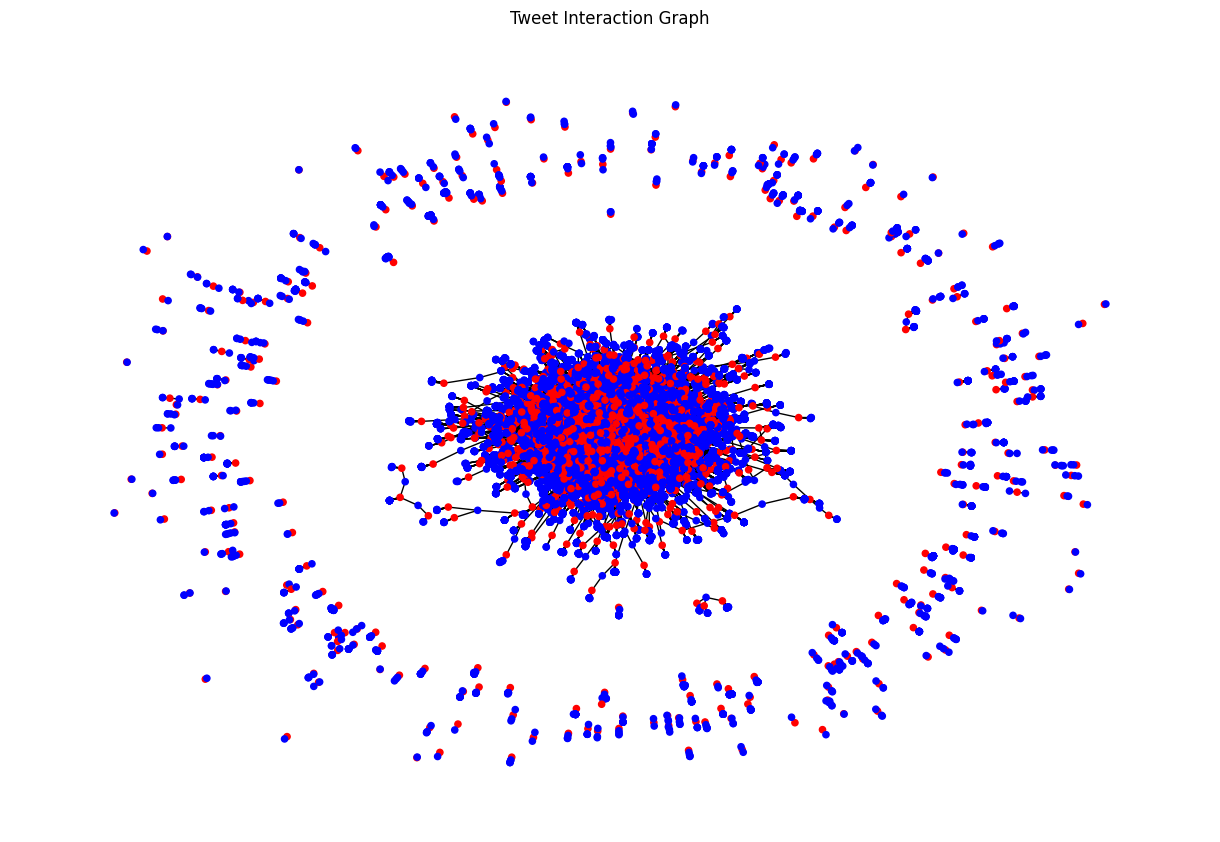

In [113]:
# Create the graph
G = nx.Graph()
for _, row in df.iterrows():
    G.add_edge(row['id'], row['reply_user_id'])

# Determine unique node types for coloring
node_types = {'id': 'red', 'reply_user_id': 'blue'}

# Initialize node colors
node_colors = {}

# Assign colors to nodes
for node in G.nodes():
    if node in df['id'].values:
        node_colors[node] = node_types['id']
    elif node in df['reply_user_id'].values:
        node_colors[node] = node_types['reply_user_id']

# Extract node colors
colors = [node_colors[node] for node in G.nodes()]



1# Layout for the graph
pos = nx.spring_layout(G)

# Plot the graph
plt.figure(figsize=(12, 8))
nx.draw(G, pos, with_labels=False, node_size=20, node_color=colors, edge_color='black')
plt.title('Tweet Interaction Graph')
plt.show()

In [114]:
# Create the graph
G = nx.Graph()
for _, row in df.iterrows():
    G.add_edge(row['id'], row['reply_user_id'])

# Determine unique node types for coloring
node_types = {'id': 'red', 'reply_user_id': 'blue'}

# Initialize node colors
node_colors = {}
for node in G.nodes():
    if node in df['id'].values:
        node_colors[node] = node_types['id']
    elif node in df['reply_user_id'].values:
        node_colors[node] = node_types['reply_user_id']

# Extract node positions using a layout
pos = nx.spring_layout(G)

# Extract edges and their positions
edge_x = []
edge_y = []
for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.extend([x0, x1, None])
    edge_y.extend([y0, y1, None])

# Extract node positions and colors
node_x = []
node_y = []
node_color = []
for node in G.nodes():
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)
    node_color.append(node_colors[node])

# Create edge trace
edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines')

# Create node trace
node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='none',
    marker=dict(
        showscale=False,
        colorscale='YlGnBu',
        color=node_color,
        size=10,
        line_width=2))

# Create the figure
fig = go.Figure(data=[edge_trace, node_trace],
                layout=go.Layout(
                    title='Tweet Interaction Graph',
                    titlefont_size=16,
                    showlegend=False,
                    hovermode='closest',
                    margin=dict(b=20, l=5, r=5, t=40),
                    annotations=[dict(
                        text="",
                        showarrow=False,
                        xref="paper", yref="paper")],
                    xaxis=dict(showgrid=False, zeroline=False),
                    yaxis=dict(showgrid=False, zeroline=False)))

# Show the figure
fig.show()

KeyboardInterrupt: 

#### Usuários que interagiram com os mesmos posts

In [ ]:
# Group by 'id' and aggregate 'user_id' into a list of unique users
grouped_df = df.groupby('id')['reply_user_id'].apply(lambda x: list(set(x)))

# Function to create co-occurrence dictionary for n-sized combinations
def create_co_occurrence(n):
    co_occurrence = {}

    # Iterate over each post and its unique users
    for users in grouped_df:
        # Create all unique n-sized combinations of users
        for combo in itertools.combinations(sorted(users), n):
            # Increment the count for each combination
            if combo in co_occurrence:
                co_occurrence[combo] += 1
            else:
                co_occurrence[combo] = 1

    # Convert the dictionary to a DataFrame
    co_occurrence_df = pd.DataFrame(
        [(list(combo), count) for combo, count in co_occurrence.items()],
        columns=['user_combination', 'count']
    )

    return co_occurrence_df

# Function to find the combinations with the highest count
def find_highest_combinations(co_occurrence_df):
    # Find the maximum count
    max_count = co_occurrence_df['count'].max()

    # Get the combinations with the highest count
    most_frequent_combinations = co_occurrence_df[co_occurrence_df['count'] == max_count]

    return most_frequent_combinations


In [ ]:
# Example usage for 2, 3, and 4 users
n = 4
co_occurrence_df = create_co_occurrence(n)
most_frequent_combinations = find_highest_combinations(co_occurrence_df)
most_frequent_combinations

In [ ]:
# Create the graph
reply_user_ids = most_frequent_combinations['user_combination'].values[0]

G = nx.Graph()
for _, row in df[df.reply_user_id.isin(reply_user_ids)].iterrows():
    G.add_edge(row['id'], row['reply_user_id'])

# Determine unique node types for coloring
node_types = {'id': 'red', 'reply_user_id': 'blue'}

# Initialize node colors
node_colors = {}
for node in G.nodes():
    if node in df['id'].values:
        node_colors[node] = node_types['id']
    elif node in df['reply_user_id'].values:
        node_colors[node] = node_types['reply_user_id']

# Extract node positions using a layout
pos = nx.spring_layout(G)

# Extract edges and their positions
edge_x = []
edge_y = []
for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.extend([x0, x1, None])
    edge_y.extend([y0, y1, None])

# Extract node positions and colors
node_x = []
node_y = []
node_color = []
for node in G.nodes():
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)
    node_color.append(node_colors[node])

# Create edge trace
edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines')

# Create node trace
node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='none',
    marker=dict(
        showscale=False,
        colorscale='YlGnBu',
        color=node_color,
        size=10,
        line_width=2))

# Create the figure
fig = go.Figure(data=[edge_trace, node_trace],
                layout=go.Layout(
                    title='Tweet Interaction Graph',
                    titlefont_size=16,
                    showlegend=False,
                    hovermode='closest',
                    margin=dict(b=20, l=5, r=5, t=40),
                    annotations=[dict(
                        text="",
                        showarrow=False,
                        xref="paper", yref="paper")],
                    xaxis=dict(showgrid=False, zeroline=False),
                    yaxis=dict(showgrid=False, zeroline=False)))

# Show the figure
fig.show()

In [ ]:


# Group by 'user_id' and aggregate 'id' into a list of unique posts
grouped_df = df.groupby('reply_user_id')['id'].apply(lambda x: list(set(x)))

# Function to create co-occurrence dictionary for n-sized combinations
def create_post_co_occurrence(n):
    co_occurrence = {}

    # Iterate over each user's posts
    for posts in grouped_df:
        # Create all unique n-sized combinations of posts
        for combo in itertools.combinations(sorted(posts), n):
            # Increment the count for each combination
            if combo in co_occurrence:
                co_occurrence[combo] += 1
            else:
                co_occurrence[combo] = 1

    # Convert the dictionary to a DataFrame
    co_occurrence_df = pd.DataFrame(
        [(list(combo), count) for combo, count in co_occurrence.items()],
        columns=['post_combination', 'count']
    )

    return co_occurrence_df

# Function to find the combinations with the highest count
def find_highest_post_combinations(co_occurrence_df):
    # Find the maximum count
    max_count = co_occurrence_df['count'].max()

    # Get the combinations with the highest count
    most_frequent_combinations = co_occurrence_df[co_occurrence_df['count'] == max_count]

    return most_frequent_combinations

In [ ]:

# Example usage for 2, 3, and 4 posts
n = 5
co_occurrence_df = create_post_co_occurrence(n)
most_frequent_post_combinations = find_highest_post_combinations(co_occurrence_df)
most_frequent_post_combinations

In [ ]:
# Create the graph
post_ids = most_frequent_post_combinations['post_combination'].values[0]

G = nx.Graph()
for _, row in df[df.id.isin(post_ids)].iterrows():
    G.add_edge(row['id'], row['reply_user_id'])

# Determine unique node types for coloring
node_types = {'id': 'red', 'reply_user_id': 'blue'}

# Initialize node colors
node_colors = {}
for node in G.nodes():
    if node in df['id'].values:
        node_colors[node] = node_types['id']
    elif node in df['reply_user_id'].values:
        node_colors[node] = node_types['reply_user_id']

# Extract node positions using a layout
pos = nx.spring_layout(G)

# Extract edges and their positions
edge_x = []
edge_y = []
for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.extend([x0, x1, None])
    edge_y.extend([y0, y1, None])

# Extract node positions and colors
node_x = []
node_y = []
node_color = []
for node in G.nodes():
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)
    node_color.append(node_colors[node])

# Create edge trace
edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines')

# Create node trace
node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='none',
    marker=dict(
        showscale=False,
        colorscale='YlGnBu',
        color=node_color,
        size=10,
        line_width=2))

# Create the figure
fig = go.Figure(data=[edge_trace, node_trace],
                layout=go.Layout(
                    title='Tweet Interaction Graph',
                    titlefont_size=16,
                    showlegend=False,
                    hovermode='closest',
                    margin=dict(b=20, l=5, r=5, t=40),
                    annotations=[dict(
                        text="",
                        showarrow=False,
                        xref="paper", yref="paper")],
                    xaxis=dict(showgrid=False, zeroline=False),
                    yaxis=dict(showgrid=False, zeroline=False)))

# Show the figure
fig.show()

In [ ]:
# Calculate graph measures
# Create a directed graph
G = nx.DiGraph()

# Add edges from the dataset
for _, row in df.iterrows():
    G.add_edge(row['id'], row['reply_user_id'])


degree_dist = dict(G.degree())
in_degree_dist = dict(G.in_degree())
out_degree_dist = dict(G.out_degree())
clustering_coefficient = nx.clustering(G)
average_path_length = nx.average_shortest_path_length(G) if nx.is_connected(G.to_undirected()) else None
density = nx.density(G)
connected_components = list(nx.connected_components(G.to_undirected()))
centrality = nx.degree_centrality(G)



In [ ]:
centrality

In [ ]:
clustering_coefficient

In [ ]:
density*100

In [ ]:
connected_components[0]